In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder,LabelEncoder, OneHotEncoder, TargetEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures, QuantileTransformer, PowerTransformer
from sklearn.model_selection import train_test_split 

from sklearn.preprocessing import PolynomialFeatures

from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import category_encoders as ce

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

from sklearn.metrics import mean_absolute_percentage_error


In [2]:
def plot_2_error(y_true, y_predicted):
    residuals = (y_true - y_predicted)/y_predicted
    max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
    max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
    max_true, max_pred = y_true[max_idx], y_predicted[max_idx]
    mape = mean_absolute_percentage_error(y_true, y_predicted)
    print("Max Error:", "{:,.0f}".format(max_error))
    print(' ')
    print('----------------------')
    print("   MAPE Error:", "{:,.2f}".format(mape*100))
    print('----------------------')

    ## Plot predicted vs true
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    from statsmodels.graphics.api import abline_plot
    ax[0].scatter(y_predicted, y_true, color="black", alpha=0.25)
    abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
    ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
    ax[0].grid(True)
    ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
    ax[0].legend()

    ## Plot predicted vs residuals
    ax[1].scatter(y_predicted, residuals, color="red", alpha=0.25)
    ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
    ax[1].grid(True)
    ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
    ax[1].hlines(y=0, xmin=np.min(y_predicted), xmax=np.max(y_predicted))
    ax[1].legend()
    plt.show()

## Сложные преобразования и заполнения пропущенных данных

In [3]:
df = pd.read_csv('Diamants/dim_train.csv')
df.tail()

,carat,cut,color,clarity,depth,table,price,x,y,z
37753,0.33,Premium,G,SI1,59.8,58.0,631,4.54,4.52,2.71
37754,2.01,Fair,F,SI1,58.6,95.0,13387,8.32,8.31,4.87
37755,0.26,Ideal,E,VVS2,61.5,56.0,769,4.11,4.08,2.52
37756,0.40,Very Good,G,SI1,62.8,60.0,702,4.66,4.70,2.94
37757,0.30,Ideal,D,SI1,62.4,54.0,508,4.32,4.34,2.70


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37758 entries, 0 to 37757
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    37758 non-null  float64
 1   cut      37758 non-null  object 
 2   color    37758 non-null  object 
 3   clarity  37758 non-null  object 
 4   depth    37758 non-null  float64
 5   table    37758 non-null  float64
 6   price    37758 non-null  int64  
 7   x        37758 non-null  float64
 8   y        37758 non-null  float64
 9   z        37758 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 2.9+ MB


In [5]:
df.describe()

,carat,depth,table,price,x,y,z
count,37758.000000,37758.000000,37758.000000,37758.000000,37758.000000,37758.000000,37758.000000
mean,0.798777,61.755085,57.460784,3932.113300,5.732871,5.736693,3.539717
std,0.474574,1.440063,2.230229,3980.261121,1.122451,1.154608,0.695749
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,953.000000,4.720000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2404.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5345.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,8.060000


In [6]:
df['y']=np.where(df['y']>=15, df['y']/10,df['y'])
df['z']=np.where(df['z']>=15, df['z']/10,df['z'])
#df.sort_values(by=['y'])

In [7]:
df.describe()

,carat,depth,table,price,x,y,z
count,37758.000000,37758.000000,37758.000000,37758.000000,37758.000000,37758.000000,37758.000000
mean,0.798777,61.755085,57.460784,3932.113300,5.732871,5.734531,3.539717
std,0.474574,1.440063,2.230229,3980.261121,1.122451,1.113751,0.695749
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,953.000000,4.720000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2404.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5345.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,10.540000,8.060000


In [8]:
cat_features = ['cut','color']
axis_features = ['x','y','z']
num_features = ['carat','depth','table']

y = np.array(df.price)
X = df.drop(columns=['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
OneHotEncoder(sparse_output=False).set_output(transform="pandas").fit_transform(df[cat_features])

,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
37753,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
37754,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
37755,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
37756,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Расширенные преобразования в энкодоре

In [10]:
print(cat_features)
print(axis_features)
print(num_features)

['cut', 'color']
['x', 'y', 'z']
['carat', 'depth', 'table']


In [11]:
import category_encoders as ce

axis_transformer = Pipeline(steps=[
    ('missing_num', IterativeImputer(missing_values=0, max_iter=20)),
    ('polynom', PolynomialFeatures(2,include_bias=False)),
    ('scaler', StandardScaler())])

num = Pipeline(steps=[
    ('missing_num', IterativeImputer(missing_values=0, max_iter=20)),
    ('scaler', StandardScaler())])

clarity_map = [{
    'col':'clarity',##### Обратить внимание
    'mapping':{'FL':10, 'IF':9, 'VVS1':8, 'VVS2':7, 'VS1':6, 'VS2':5, 
               'SI1':4, 'SI2':3, 'I1':2, 'I2':1, 'I3':0}
    }]

clarity_transformer = Pipeline(steps=[
    ('missing_num', SimpleImputer(strategy = 'most_frequent')),
    ('ce',ce.OrdinalEncoder(mapping=clarity_map)),
    ('scaler', MinMaxScaler())
    ])    
    
CT = ColumnTransformer([
        ("axis_transformer", axis_transformer, axis_features),
        ("num", num, num_features),
        # убрать быстую разряженную 
        ("cat", OneHotEncoder(sparse_output=False), cat_features),
        ("ordinal_map", clarity_transformer, ['clarity'])##### Обратить внимание
        ]).set_output(transform='pandas')

display(CT)

ct = CT.fit_transform(X_train)
pd.DataFrame(ct).head().T


,transformers,"[('axis_transformer', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,estimator,None
,missing_values,0
,sample_posterior,False


,25885,1804,1844,27396,24691
axis_transformer__x,1.056232,-0.400341,-1.159904,0.627303,-1.240328
axis_transformer__y,0.999431,-0.431690,-1.196755,0.657402,-1.286763
axis_transformer__z,1.021656,-0.554696,-1.191022,0.602260,-1.234408
axis_transformer__x^2,1.023525,-0.462358,-1.079824,0.544753,-1.138886
axis_transformer__x y,0.991727,-0.476137,-1.094351,0.561699,-1.156728
axis_transformer__x z,1.007616,-0.531442,-1.093979,0.533832,-1.139483
axis_transformer__y^2,0.959015,-0.489851,-1.108340,0.578146,-1.173955
axis_transformer__y z,0.975531,-0.545106,-1.108322,0.550502,-1.157176
axis_transformer__z^2,0.983900,-0.596752,-1.103069,0.517957,-1.134831
num__carat,0.885971,-0.570317,-0.992430,0.442753,-1.034641


In [12]:
model = Pipeline(steps=[
    ('preproc', CT),
    ('estimator', Ridge())
    ])

model.fit(X_train, y_train)

,steps,"[('preproc', ...), ('estimator', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('axis_transformer', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [13]:
model.score(X_train, y_train)

0.9170155639987316

In [14]:
model.score(X_test, y_test)

0.911423122494545

Max Error: 2,729
 
----------------------
   MAPE Error: 40.35
----------------------


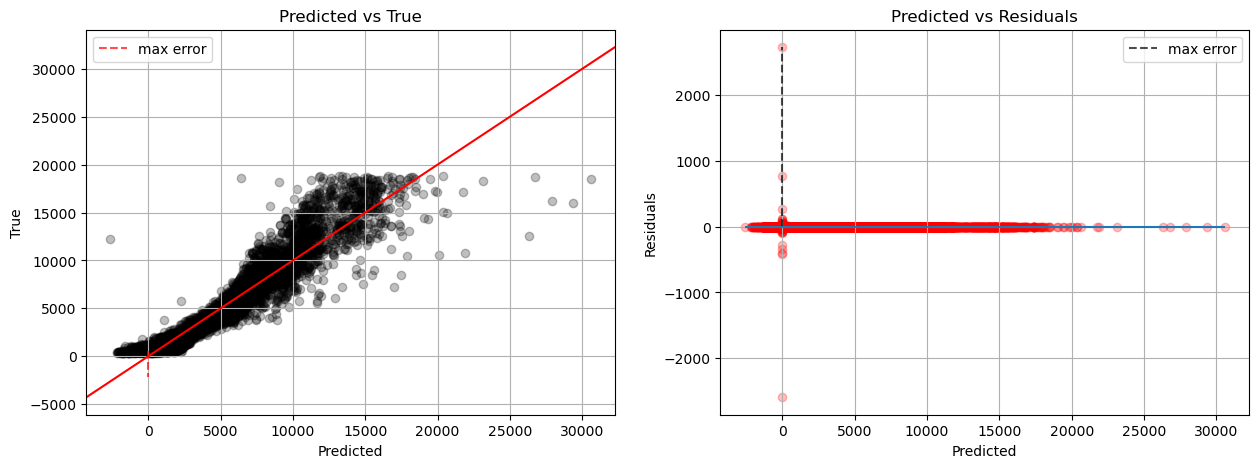

In [15]:
plot_2_error(y_test, model.predict(X_test))

<Axes: >

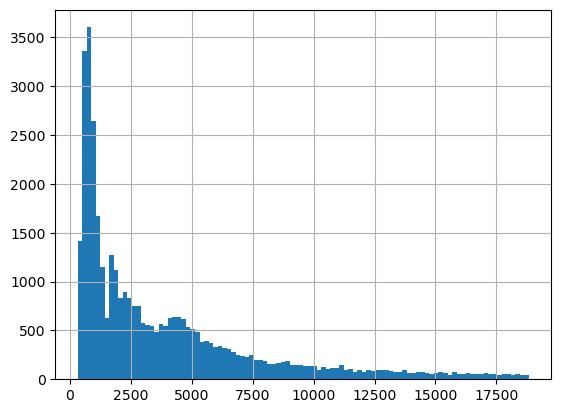

In [16]:
df['price'].hist(bins=100)

In [17]:
model_target =  TransformedTargetRegressor(
                regressor = Pipeline(steps=[
                                ('preproc', CT),
                                ('estimator', Ridge())
                            ]),
                transformer=QuantileTransformer(n_quantiles=1000, output_distribution="normal")
)

model_target.fit(X_train, y_train)

,regressor,"Pipeline(step...r', Ridge())])"
,transformer,QuantileTrans...tion='normal')
,func,None
,inverse_func,None
,check_inverse,True
,transformers,"[('axis_transformer', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


Max Error: 36
 
----------------------
   MAPE Error: 12.83
----------------------


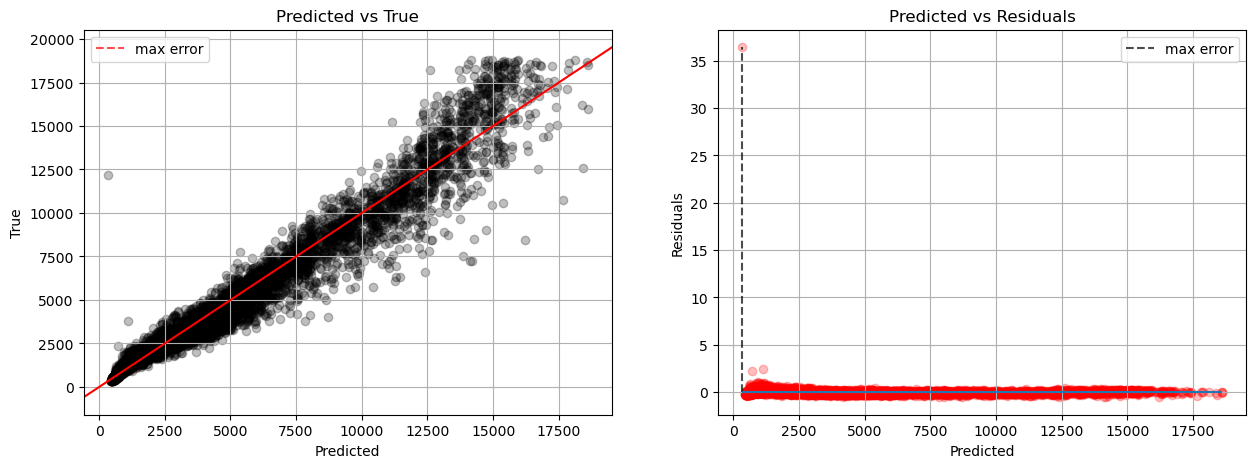

In [18]:
plot_2_error(y_test, model_target.predict(X_test))

Max Error: 8
 
----------------------
   MAPE Error: 11.29
----------------------


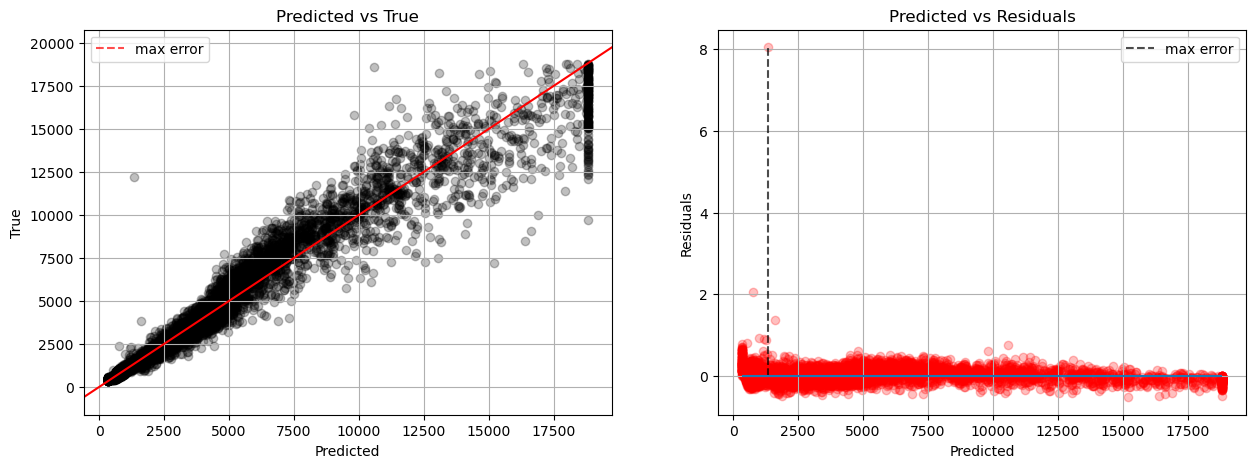

In [19]:
model_target =  TransformedTargetRegressor(
                regressor = Pipeline(steps=[
                                ('preproc', CT),
                                ('estimator', Ridge())
                            ]),
                transformer=QuantileTransformer(n_quantiles=1000, output_distribution="uniform")
)

model_target.fit(X_train, y_train)
plot_2_error(y_test, model_target.predict(X_test))

Вспомнили датасет про стоимость домов? А может это решение :)

Max Error: 14
 
----------------------
   MAPE Error: 10.54
----------------------


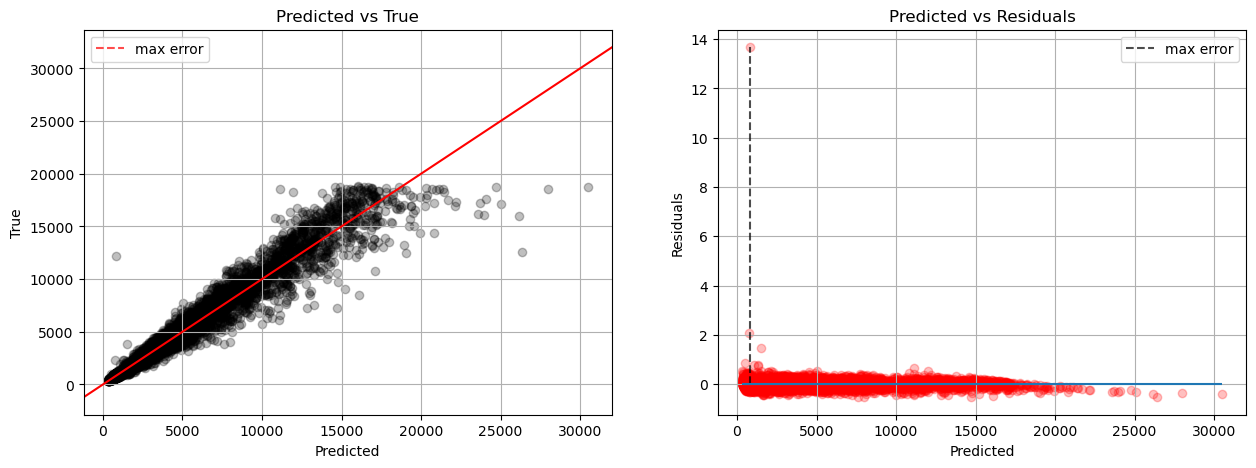

In [20]:
model_target =  TransformedTargetRegressor(
                regressor = Pipeline(steps=[
                                ('preproc', CT),
                                ('estimator', Ridge())
                            ]),
                transformer=PowerTransformer()
)

model_target.fit(X_train, y_train)
plot_2_error(y_test, model_target.predict(X_test))

In [21]:
model_pipe = Pipeline([
                ('model', TransformedTargetRegressor(
                        regressor = Pipeline(steps=[
                                ('preproc', CT),
                                ('estimator', Ridge())
                            ]),
                        transformer=PowerTransformer(),
                        check_inverse = False)
                )])
model_pipe                 

,steps,"[('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,regressor,"Pipeline(step...r', Ridge())])"
,transformer,PowerTransformer()
,func,None
,inverse_func,None
,check_inverse,False
,transformers,"[('axis_transformer', ...), ('num', ...), ...]"
,remainder,'drop'


In [22]:

param_grid = [
    {'model__regressor__estimator':[Ridge(), KNeighborsRegressor()],
     'model__transformer':[PowerTransformer(),QuantileTransformer(n_quantiles=1000, output_distribution="uniform")]}
]

scores='neg_mean_absolute_percentage_error'
grid = GridSearchCV(model_pipe, n_jobs=1, param_grid=param_grid, scoring=scores)
grid.fit(X_train, y_train)

,estimator,Pipeline(step...nsformer()))])
,param_grid,"[{'model__regressor__estimator': [Ridge(), KNeighborsRegressor()], 'model__transformer': [PowerTransformer(), QuantileTransformer()]}]"
,scoring,'neg_mean_absolute_percentage_error'
,n_jobs,1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,regressor,"Pipeline(step...r', Ridge())])"


In [23]:
grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

,0,1,2,3
mean_fit_time,0.102064,0.095517,0.119968,0.106289
std_fit_time,0.004849,0.003274,0.019892,0.002259
mean_score_time,0.02064,0.021149,0.222574,0.21599
std_score_time,0.000262,0.00119,0.032553,0.017008
param_model__regressor__estimator,Ridge(),Ridge(),KNeighborsRegressor(),KNeighborsRegressor()
param_model__transformer,PowerTransformer(),QuantileTransformer(),PowerTransformer(),QuantileTransformer()
params,"{'model__regressor__estimator': Ridge(), 'mode...","{'model__regressor__estimator': Ridge(), 'mode...",{'model__regressor__estimator': KNeighborsRegr...,{'model__regressor__estimator': KNeighborsRegr...
split0_test_score,-0.103979,-0.113186,-0.133534,-0.134906
split1_test_score,-0.104688,-0.112531,-0.130709,-0.131715
split2_test_score,-0.105615,-0.114176,-0.134829,-0.136361


In [24]:
param_grid = [
    {'model__regressor__estimator':[KNeighborsRegressor()],
     'model__regressor__estimator__n_neighbors': [3,5],
     'model__transformer':[PowerTransformer(),QuantileTransformer(n_quantiles=1000, output_distribution="uniform")]},
    {'model__regressor__preproc__num__scaler': [StandardScaler(), RobustScaler()],
     'model__regressor__preproc__ordinal_map__ce':[ce.OrdinalEncoder(mapping=clarity_map), TargetEncoder()],
     'model__regressor__estimator':[Ridge()],
     'model__regressor__estimator__alpha': [0.1,1],
     'model__transformer':[PowerTransformer(),QuantileTransformer(n_quantiles=1000, output_distribution="uniform")]},
]
    
scores='neg_mean_absolute_percentage_error'
grid_2 = GridSearchCV(model_pipe, n_jobs=1, param_grid=param_grid, scoring=scores)
grid_2.fit(X_train, y_train)

,estimator,Pipeline(step...nsformer()))])
,param_grid,"[{'model__regressor__estimator': [KNeighborsRegressor()], 'model__regressor__estimator__n_neighbors': [3, 5], 'model__transformer': [PowerTransformer(), QuantileTransformer()]}, {'model__regressor__estimator': [Ridge()], 'model__regressor__estimator__alpha': [0.1, 1], 'model__regressor__preproc__num__scaler': [StandardScaler(), RobustScaler()], 'model__regressor__preproc__ordinal_map__ce': [OrdinalEncode...type: int64}]), TargetEncoder()], ...}]"
,scoring,'neg_mean_absolute_percentage_error'
,n_jobs,1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,regressor,Pipeline(step...(alpha=0.1))])


In [25]:
grid_result = pd.DataFrame(grid_2.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

,8,4,16,12,6,10,9,5,14,18,17,13,7,11,19,15,2,3,0,1
mean_fit_time,0.108553,0.110374,0.101024,0.107641,0.111871,0.098564,0.096798,0.098007,0.121408,0.100324,0.09713,0.095325,0.08977,0.089734,0.096494,0.099116,0.104992,0.096822,0.129361,0.147759
std_fit_time,0.004635,0.013226,0.002458,0.007174,0.011472,0.002519,0.006117,0.006024,0.032974,0.003522,0.007823,0.007523,0.005989,0.001216,0.005224,0.006229,0.006985,0.0039,0.031206,0.054062
mean_score_time,0.030693,0.032433,0.019913,0.021287,0.020987,0.019356,0.02074,0.026573,0.043665,0.019741,0.022295,0.031721,0.019786,0.020091,0.020651,0.019843,0.185898,0.198132,0.222406,0.507707
std_score_time,0.0145,0.011013,0.001417,0.001722,0.002328,0.001454,0.000577,0.012003,0.027586,0.002082,0.001359,0.017661,0.001862,0.002692,0.000385,0.00231,0.044009,0.018325,0.030796,0.289716
param_model__regressor__estimator,Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor()
param_model__regressor__estimator__n_neighbors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,3.0,3.0
param_model__transformer,PowerTransformer(),PowerTransformer(),PowerTransformer(),PowerTransformer(),PowerTransformer(),PowerTransformer(),QuantileTransformer(),QuantileTransformer(),PowerTransformer(),PowerTransformer(),QuantileTransformer(),QuantileTransformer(),QuantileTransformer(),QuantileTransformer(),QuantileTransformer(),QuantileTransformer(),PowerTransformer(),QuantileTransformer(),PowerTransformer(),QuantileTransformer()
param_model__regressor__estimator__alpha,0.1,0.1,1.0,1.0,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0,0.1,0.1,1.0,1.0,NaN,NaN,NaN,NaN
param_model__regressor__preproc__num__scaler,RobustScaler(),StandardScaler(),RobustScaler(),StandardScaler(),StandardScaler(),RobustScaler(),RobustScaler(),StandardScaler(),StandardScaler(),RobustScaler(),RobustScaler(),StandardScaler(),StandardScaler(),RobustScaler(),RobustScaler(),StandardScaler(),NaN,NaN,NaN,NaN
param_model__regressor__preproc__ordinal_map__ce,"OrdinalEncoder(mapping=[{'col': 'clarity', 'da...","OrdinalEncoder(mapping=[{'col': 'clarity', 'da...","OrdinalEncoder(mapping=[{'col': 'clarity', 'da...","OrdinalEncoder(mapping=[{'col': 'clarity', 'da...",TargetEncoder(),TargetEncoder(),"OrdinalEncoder(mapping=[{'col': 'clarity', 'da...","OrdinalEncoder(mapping=[{'col': 'clarity', 'da...",TargetEncoder(),TargetEncoder(),"OrdinalEncoder(mapping=[{'col': 'clarity', 'da...","OrdinalEncoder(mapping=[{'col': 'clarity', 'da...",TargetEncoder(),TargetEncoder(),TargetEncoder(),TargetEncoder(),NaN,NaN,NaN,NaN


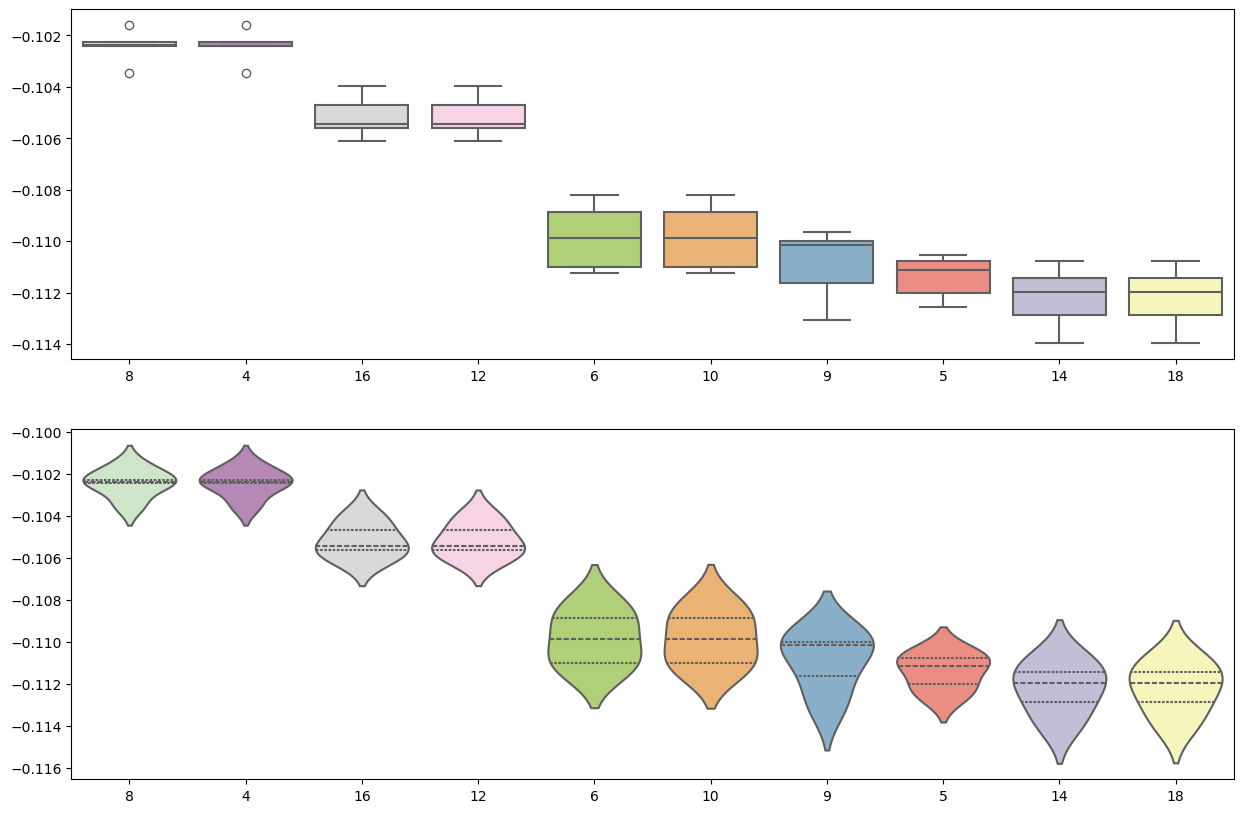

In [32]:
mask = grid_result.index[grid_result.index.str.endswith("_test_score")][:-3]
tabl = grid_result.loc[mask].iloc[:,:10]
tabl.columns = tabl.columns.astype(str)
f, ax = plt.subplots(2,1,figsize=(15, 10))
sns.boxplot(data=tabl,  linewidth=1.5, palette="Set3_r", ax=ax[0]);
sns.violinplot(data=tabl, inner="quart", linewidth=1.5, palette="Set3_r", ax=ax[1]);

In [49]:
final = grid_2.best_estimator_

Max Error: 181
 
----------------------
   MAPE Error: 10.29
----------------------


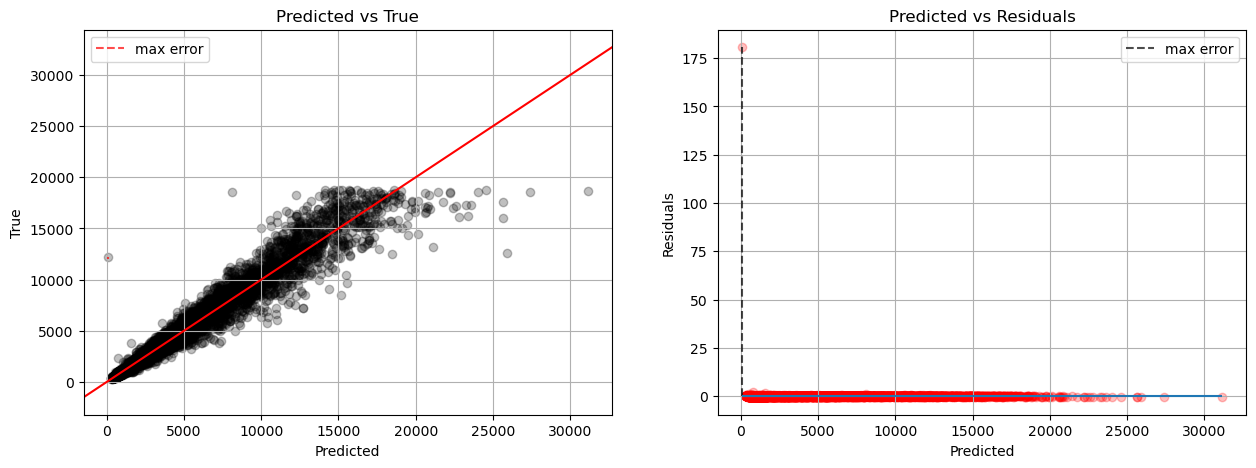

In [50]:
final.fit(X_train, y_train)
plot_2_error(y_test, final.predict(X_test))